## Uncertainty analysis with Gender-based information
### Author: Deb Debnath

#### Data loading

In [1]:
import warnings
import logging
import ipywidgets as widgets
from dataclasses import dataclass, field
from typing import Optional, Sequence

In [2]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.resolve()))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix
from src.threshold import plot_uncertainty_at_threshold, plot_v_plot
from src.classifier import z_score, linear_classifier_score, linear_classifier_subscores, antilogit_classifier_score
from src.dist_fitting import (
    test_gamma_fit, 
    test_lognormal_fit_ks,
    test_negative_binomial_fit, 
    test_poisson_fit, 
    test_zero_inflated_poisson_fit,
    test_zero_inflated_negative_binomial_fit
)
from src.random_sample import (
    sample_zero_inflated_poisson,
    sample_zero_inflated_negative_binomial,
    sample_poisson_mean_rsd,
    sample_zero_inflated_poisson_mean_rsd,
    sample_negative_binomial_mean_rsd,
    sample_zero_inflated_negative_binomial_mean_rsd,
    sample_gamma_mean_rsd,
    sample_lognormal_mean_rsd
)
from src.postprocessing import (
    plot_confusion_matrix,
    display_differential_classification_results_one_threshold,
    display_differential_classification_results_two_thresholds,
    calculate_sens_spec_dual_threshold,
    calculate_subject_wise_agreement,
    calculate_subject_wise_disagreement
)

In [4]:
warnings.filterwarnings("ignore")

In [5]:
raw_data = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=1
)
pathos = pd.read_excel(
    "../../raw_data/Purdue expanded info AD subject sample added Info Apoe.xlsx"
)

In [6]:
pathos = pathos.set_index("Isolate ID")
raw_data = raw_data.set_index("gene_id")

In [7]:
pathos = pathos[["Disease", "Gender"]]

#### Setting parameters

In [8]:
mean_TPM = 10
num_patients = 243
seed = 321
single_thres = 0.85
dual_thres_low, dual_thres_high = 0.15, 0.85
n_samples = 1000
uncertainties = list(range(10, 55, 5))

In [9]:
np.random.seed(seed)

#### Data preprocessing

In [10]:
pathos = pathos.dropna()
pathos = pathos.loc[pathos.index.dropna(), :]
pathos.index = pathos.index.astype(int).astype(str)

In [11]:
patients_df = raw_data[~raw_data.loc[:, "Coeff"].isnull()]
coefficients = np.nan_to_num(np.array(patients_df.loc[:, "Coeff"]))
patients_df = patients_df.filter(regex=r"^\d+")
genes = patients_df.index.values

In [12]:
grouped_cols = patients_df.columns.str.split("-").str[0]
grouped = patients_df.groupby(grouped_cols, axis=1)
patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
patients_df.index = genes

In [13]:
for col in patients_df.columns:
    if col not in pathos.index:
        print(col)

17906


In [14]:
for col in pathos.index:
    if col not in patients_df.columns:
        pathos = pathos.drop(col)

In [15]:
# Assuming NCI and Female for 17906 (missing from pathos data)
pathos.loc["17906", ["Disease", "Gender"]] = "NCI", "Female"

In [16]:
patients_df = patients_df.loc[:, pathos.index]

#### Conversion to Z-scores and dropping genes below TPM threshold

In [17]:
means = patients_df.mean(axis=1)
stds = patients_df.std(axis=1)

In [18]:
z_scores_df = patients_df.apply(lambda x: z_score(x, means, stds))

In [19]:
z_scores_df = z_scores_df[means >= mean_TPM]
coefficients = coefficients[means >= mean_TPM]
patients_df = patients_df[means >= mean_TPM]

## Evaluating classifier performance by gender

## Single threshold

### Finding the Best Distribution per Gene

In [20]:
def _find_best_dist(lognormal_ks_p_val: Optional[float], gamma_ks_p_val: Optional[float], nb_ks_p_val: Optional[float]) -> Optional[str]:
    p_val_cutoff = 0.1
    subset = pd.Series(index=["lognormal", "negative binomial", "gamma"], data=[lognormal_ks_p_val, gamma_ks_p_val, nb_ks_p_val])
    subset = subset.dropna()
    if len(subset) == 0:
        return None
    subset = subset[subset >= p_val_cutoff]
    if len(subset) == 0:
        return None
    filt = (subset == subset.max())
    return subset[filt].index[0].upper()


def find_best_fit_dist(*, 
                       lognormal_ks_p_vals: pd.Series, 
                       gamma_ks_p_vals: pd.Series,
                       nb_ks_p_vals: pd.Series,
                       means: pd.Series, 
                       stds: pd.Series) -> pd.DataFrame:
    res = pd.DataFrame(index=lognormal_ks_p_vals.index, columns=["vmr", "best_fit", "gamma_ks_p_val", "lognormal_sw_p_val", "nb_ks_p_val"])
    for gene in res.index:
        res.loc[gene, "vmr"] = stds[gene]**2.0 / means[gene]
        res.loc[gene, "best_fit"] = _find_best_dist(lognormal_ks_p_vals[gene], gamma_ks_p_vals[gene], nb_ks_p_vals[gene])
        res.loc[gene, ["lognormal_ks_p_val", "gamma_ks_p_val", "nb_ks_p_val"]] = lognormal_ks_p_vals[gene], gamma_ks_p_vals[gene], nb_ks_p_vals[gene]
    return res

In [21]:
lognormal_ks_p_vals = patients_df.apply(lambda row: test_lognormal_fit_ks(row)[1], axis=1)
gamma_ks_p_vals = patients_df.apply(lambda row: test_gamma_fit(row)[1], axis=1)
nb_ks_p_vals = patients_df.apply(lambda row: test_negative_binomial_fit(row)[1], axis=1)

In [22]:
best_fit_dists = find_best_fit_dist(lognormal_ks_p_vals=lognormal_ks_p_vals, gamma_ks_p_vals=gamma_ks_p_vals, nb_ks_p_vals=nb_ks_p_vals, means=means, stds=stds)

### Simulations

In [23]:
@dataclass
class SingleThresholdResults:
    gt_list: list[np.ndarray] = field(default_factory=list)
    preds_list: list[np.ndarray] = field(default_factory=list)
    ad_diff_cls_ids: list[str] = field(default_factory=list)
    nci_diff_cls_ids: list[str] = field(default_factory=list)
    
@dataclass
class DualThresholdResults:
    gt_list: list[np.ndarray] = field(default_factory=list)
    preds_list: list[np.ndarray] = field(default_factory=list)
    ad_diff_cls_ids: list[str] = field(default_factory=list)
    int_diff_cls_ids: list[str] = field(default_factory=list)
    nci_diff_cls_ids: list[str] = field(default_factory=list)

class MultiUncertaintyResults:
    def __init__(self, uncertainties: list[int | float]):
        self.single_thres_expt_results: pd.DataFrame = pd.DataFrame(index=uncertainties, 
                                          columns=["AD", "NCI"])
        self.dual_thres_expt_results: pd.DataFrame = pd.DataFrame(index=uncertainties, 
                                      columns=["AD", "Intermediate", "NCI"])
        self.score_stats: pd.DataFrame = pd.DataFrame(index=uncertainties,
                               columns=["mean_lin", "std_lin", "mean_probs", "std_probs"])
        
        self.pos_subscore_arrs = {uncert: None for uncert in uncertainties}
        self.neg_subscore_arrs = {uncert: None for uncert in uncertainties}
        self.lin_score_arrs = {uncert: None for uncert in uncertainties}
        self.pred_prob_arrs = {uncert: None for uncert in uncertainties}
        self.single_thres_gt_arrs = {uncert: None for uncert in uncertainties}
        self.single_thres_pred_arrs = {uncert: None for uncert in uncertainties}
        self.dual_thres_gt_arrs = {uncert: None for uncert in uncertainties}
        self.dual_thres_pred_arrs = {uncert: None for uncert in uncertainties}

In [24]:
def simulate_sampling_experiment(
            tpm_df: pd.DataFrame, 
            *,
            dual_thres_1: float, 
            dual_thres_2: float,
            single_thres: float,
            diff_class_lim: int,
            uncertainty: float,
            n_samples: int,
            coefficients: np.ndarray | pd.Series, 
            best_fit_distributions: pd.Series
    ) -> tuple[SingleThresholdResults, DualThresholdResults, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Perform simulation experiments for single and dual thresholds, return the predicted and ground truth classes 
    and number of differentially classified individuals for each class, along with all predicted linear scores and probabilities.
    """
    if not 0 <= dual_thres_1 <= 1 and 0 <= dual_thres_2 <= 1 and 0 <= single_thres <= 1:
        raise ValueError("Thresholds should be between 0 and 1.")
    if dual_thres_1 == dual_thres_2:
        raise ValueError("Thresholds for two threshold simulations should be distinct.")
    if not 1 <= diff_class_lim <= n_samples:
        raise ValueError(f"The limit for differential classification should be between 1 and {n_samples}.")
    pred_linear_scores = []
    pred_probs = []
    pred_pos_subscores, pred_neg_subscores = [], []

    n_features, num_patients = tpm_df.shape
    
    # Single and dual threshold result variables
    single_thres_res = SingleThresholdResults()
    dual_thres_res = DualThresholdResults()
    
    for j in range(num_patients):
        samples = np.zeros((n_features, n_samples))
        patient_id = tpm_df.columns[j]

        for i in range(n_features):
            gene = tpm_df.index[i]
            mean = tpm_df.iloc[i, j] 
            
            # Pick the best distribution for each gene based on a suitable criterion (variance to mean ratio, VMR)
            best_fit_dist = best_fit_distributions[gene]
            if best_fit_dist is None:
                best_fit_dist = "NEGATIVE BINOMIAL"
            if best_fit_dist == "NEGATIVE BINOMIAL" and (uncertainty / 100) ** 2.0 <= 1/mean:
                best_fit_dist = "LOGNORMAL"
            
            # Sample from distribution
            match best_fit_dist:
                case "NEGATIVE BINOMIAL":
                    samples[i] = sample_negative_binomial_mean_rsd(mean, uncertainty / 100.0, n_samples)
                case "LOGNORMAL":
                    samples[i] = sample_lognormal_mean_rsd(mean, uncertainty / 100.0, n_samples)
                case "GAMMA":
                    samples[i] = sample_gamma_mean_rsd(mean, uncertainty / 100.0, n_samples)
                # case "POISSON":
                    # samples[i] = sample_poisson_mean_rsd(mean, uncertainty / 100.0, n_samples)
                # case "ZIP":
                    # samples[i] = sample_zero_inflated_poisson_mean_rsd(mean, uncertainty / 100.0, n_samples)
                # case "ZINB":
                    # samples[i] = sample_zero_inflated_negative_binomial_mean_rsd(
                                # mean, uncertainty / 100.0, discrete_dist_fitting_results.loc[gene, "zinb_pi"], n_samples)

        # Convert sampled TPMs to z-scores
        samples = z_score(samples,  means.values[:n_features, np.newaxis], stds.values[:n_features, np.newaxis])
    
        # Get predicted probabilities from z-scores
        neg_subscores, pos_subscores = linear_classifier_subscores(coefficients[:n_features], samples)
        lin_scores = pos_subscores + neg_subscores
        probs = antilogit_classifier_score(lin_scores)

        # Keep track of linear scores, positive and negative subscores and simulated probabilities
        pred_linear_scores.append(lin_scores)
        pred_probs.append(probs)
        pred_pos_subscores.append(pos_subscores)
        pred_neg_subscores.append(neg_subscores)
    
        # Get ground truth probabilities from original TPMs
        tpm_z_scores = z_score(tpm_df.iloc[:, j], means[tpm_df.index], stds[tpm_df.index])
        res = (tpm_df.iloc[:, j] - means[:n_features]) / stds[:n_features]
        y_0 = antilogit_classifier_score(linear_classifier_score(coefficients, tpm_z_scores))

        # Single threshold calculations
        gt_label = 0 if y_0 < single_thres else 1
        
        preds = np.zeros(n_samples, dtype=np.int64)
        preds[(single_thres <= probs)] = 1 

        if np.sum(preds != gt_label) >= diff_class_lim:
            if gt_label == 0:
                single_thres_res.ad_diff_cls_ids.append(patient_id)
            else:
                single_thres_res.nci_diff_cls_ids.append(patient_id)
            
        gt_arr = np.ones(n_samples, dtype=np.int64) * gt_label
        single_thres_res.gt_list.append(gt_arr)
        single_thres_res.preds_list.append(preds)

        # Dual threshold calculations
        if y_0 < dual_thres_1:
            gt_label = 0
        elif dual_thres_1 <= y_0 < dual_thres_2:
            gt_label = 1
        else:
            gt_label = 2

        preds = np.zeros(n_samples, dtype=np.int64)
        preds[(dual_thres_1 <= probs) & (probs < dual_thres_2)] = 1 
        preds[probs >= dual_thres_2] = 2
        
        if np.sum(preds != gt_label) >= diff_class_lim:
            match gt_label:
                case 0:
                    dual_thres_res.nci_diff_cls_ids.append(patient_id)
                case 1:
                    dual_thres_res.int_diff_cls_ids.append(patient_id)
                case 2:
                    dual_thres_res.ad_diff_cls_ids.append(patient_id)
        
        gt_arr = np.ones(n_samples, dtype=np.int64) * gt_label
        dual_thres_res.gt_list.append(gt_arr)
        dual_thres_res.preds_list.append(preds)
            
    lin_scores_all = np.hstack(pred_linear_scores)
    pred_probs_all = np.hstack(pred_probs)
            
    pos_subscores_all = np.hstack(pred_pos_subscores)
    neg_subscores_all = np.hstack(pred_neg_subscores)
    return (single_thres_res, dual_thres_res, neg_subscores_all, 
            pos_subscores_all, lin_scores_all, pred_probs_all)

In [25]:
def simulate_multiple_uncertainties(tpm_df: pd.DataFrame, uncertainties: list[int | float], *, 
                                    thres_low: float, thres_high: float, single_thres: float, 
                                    coefficients: pd.Series, best_fit_distributions: pd.Series, diff_class_lim: int, 
                                    n_samples: int = 1000) -> MultiUncertaintyResults:
    """
    Run simulation of MC sampling for multiple values of uncertainties for a given dataset and criteria.
    """
    res  = MultiUncertaintyResults(uncertainties)
    for uncertainty in uncertainties:
        single_thres_res, dual_thres_res, neg_subscores, pos_subscores, lin_scores, pred_probs = simulate_sampling_experiment(
                        tpm_df, dual_thres_1=thres_low, dual_thres_2=thres_high, 
                        single_thres=single_thres, coefficients=coefficients, 
                        uncertainty=uncertainty, diff_class_lim=diff_class_lim,
                        n_samples=n_samples, best_fit_distributions=best_fit_distributions)
        res.single_thres_gt_arrs[uncertainty], res.single_thres_pred_arrs[uncertainty] = np.hstack(single_thres_res.gt_list), np.hstack(single_thres_res.preds_list)
        res.dual_thres_gt_arrs[uncertainty], res.dual_thres_pred_arrs[uncertainty] = np.hstack(dual_thres_res.gt_list), np.hstack(dual_thres_res.preds_list)
        res.lin_score_arrs[uncertainty], res.pred_prob_arrs[uncertainty] = lin_scores, pred_probs
        res.pos_subscore_arrs[uncertainty], res.neg_subscore_arrs[uncertainty] = pos_subscores, neg_subscores
        res.single_thres_expt_results.loc[uncertainty, "AD"] = single_thres_res.ad_diff_cls_ids
        res.single_thres_expt_results.loc[uncertainty, "NCI"] = single_thres_res.nci_diff_cls_ids
        res.dual_thres_expt_results.loc[uncertainty, "AD"] = dual_thres_res.ad_diff_cls_ids
        res.dual_thres_expt_results.loc[uncertainty, "Intermediate"] = dual_thres_res.int_diff_cls_ids
        res.dual_thres_expt_results.loc[uncertainty, "NCI"] = dual_thres_res.nci_diff_cls_ids
        res.score_stats.loc[uncertainty, "mean_lin"] = np.mean(lin_scores)
        res.score_stats.loc[uncertainty, "std_lin"] = np.std(lin_scores)
        res.score_stats.loc[uncertainty, "mean_probs"] = np.mean(pred_probs)
        res.score_stats.loc[uncertainty, "std_probs"] = np.std(pred_probs)
    return res

In [26]:
res_1_diff_cls = simulate_multiple_uncertainties(patients_df, uncertainties, 
                                    thres_low=dual_thres_low, thres_high=dual_thres_high, single_thres=single_thres, coefficients=coefficients,
                                    best_fit_distributions=best_fit_dists["best_fit"], diff_class_lim=1, 
                                    n_samples=n_samples)
res = simulate_multiple_uncertainties(patients_df, uncertainties, 
                                    thres_low=dual_thres_low, thres_high=dual_thres_high, single_thres=single_thres, coefficients=coefficients,
                                    best_fit_distributions=best_fit_dists["best_fit"], diff_class_lim=int(0.10*n_samples), 
                                    n_samples=n_samples)

In [27]:
gt_probs = antilogit_classifier_score(np.sum(coefficients[:, np.newaxis] * z_scores_df, axis=0))

In [28]:
def visualize_differential_classification_results(results: pd.DataFrame, title: str, y_lim: tuple[float, float]) -> None:
    for cat in results.columns:
        plt.plot(results.index, results.loc[:, cat] * 100, label=cat.replace("_", ", "))
    plt.xlabel("Pct. uncertainty")
    plt.ylabel("Percent of subjects within category differentially classified")
    plt.title(title)
    plt.ylim(y_lim)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncols=max(2, len(results.columns) // 2))

In [29]:
def count_male_female(id_list_series: pd.Series, pathos: pd.DataFrame) -> tuple[pd.Series, pd.Series]:
    cat = id_list_series.name
    is_male = id_list_series.apply(lambda idx_list: np.array([pathos.loc[idx, "Gender"] == "Male" for idx in idx_list]))
    num_male, num_female = is_male.apply(lambda arr: arr.sum()), is_male.apply(lambda arr: arr.shape[0] - arr.sum())
    num_male.name = f"{cat}_male"
    num_female.name = f"{cat}_female"
    return num_male, num_female

In [30]:
def calculate_subgroup_fractions(*, 
                                 results: pd.DataFrame, 
                                 pathos_df: pd.DataFrame, 
                                 category: str) -> pd.DataFrame:
    results[f"{category}_male"], results[f"{category}_female"] = count_male_female(results[category], pathos_df)
    results[category] = results[f"{category}_male"] + results[f"{category}_female"]
    gender_group = pathos_df.groupby("Gender")
    num_male, num_female = (gender_group.get_group("Male")["Disease (predicted)"] == category).sum(), (gender_group.get_group("Female")["Disease (predicted)"] == category).sum()
    results[f"{category}_male"] /= num_male
    results[f"{category}_female"] /= num_female
    results[category] /= (num_male + num_female)
    return results    

In [31]:
single_thres_pathos = pathos.copy(deep=True)
single_thres_pathos["Disease (predicted)"] = gt_probs.apply(lambda pred: "AD" if pred >= single_thres else "NCI")

single_thres_pct_diff_cls_1_diff_cls = res_1_diff_cls.single_thres_expt_results.copy(deep=True)
single_thres_pct_diff_cls = res.single_thres_expt_results.copy(deep=True)

single_thres_pct_diff_cls_1_diff_cls = calculate_subgroup_fractions(results=single_thres_pct_diff_cls_1_diff_cls, pathos_df=single_thres_pathos, category="AD")
single_thres_pct_diff_cls_1_diff_cls = calculate_subgroup_fractions(results=single_thres_pct_diff_cls_1_diff_cls, pathos_df=single_thres_pathos, category="NCI")

single_thres_pct_diff_cls = calculate_subgroup_fractions(results=single_thres_pct_diff_cls, pathos_df=single_thres_pathos, category="AD")
single_thres_pct_diff_cls = calculate_subgroup_fractions(results=single_thres_pct_diff_cls, pathos_df=single_thres_pathos, category="NCI")

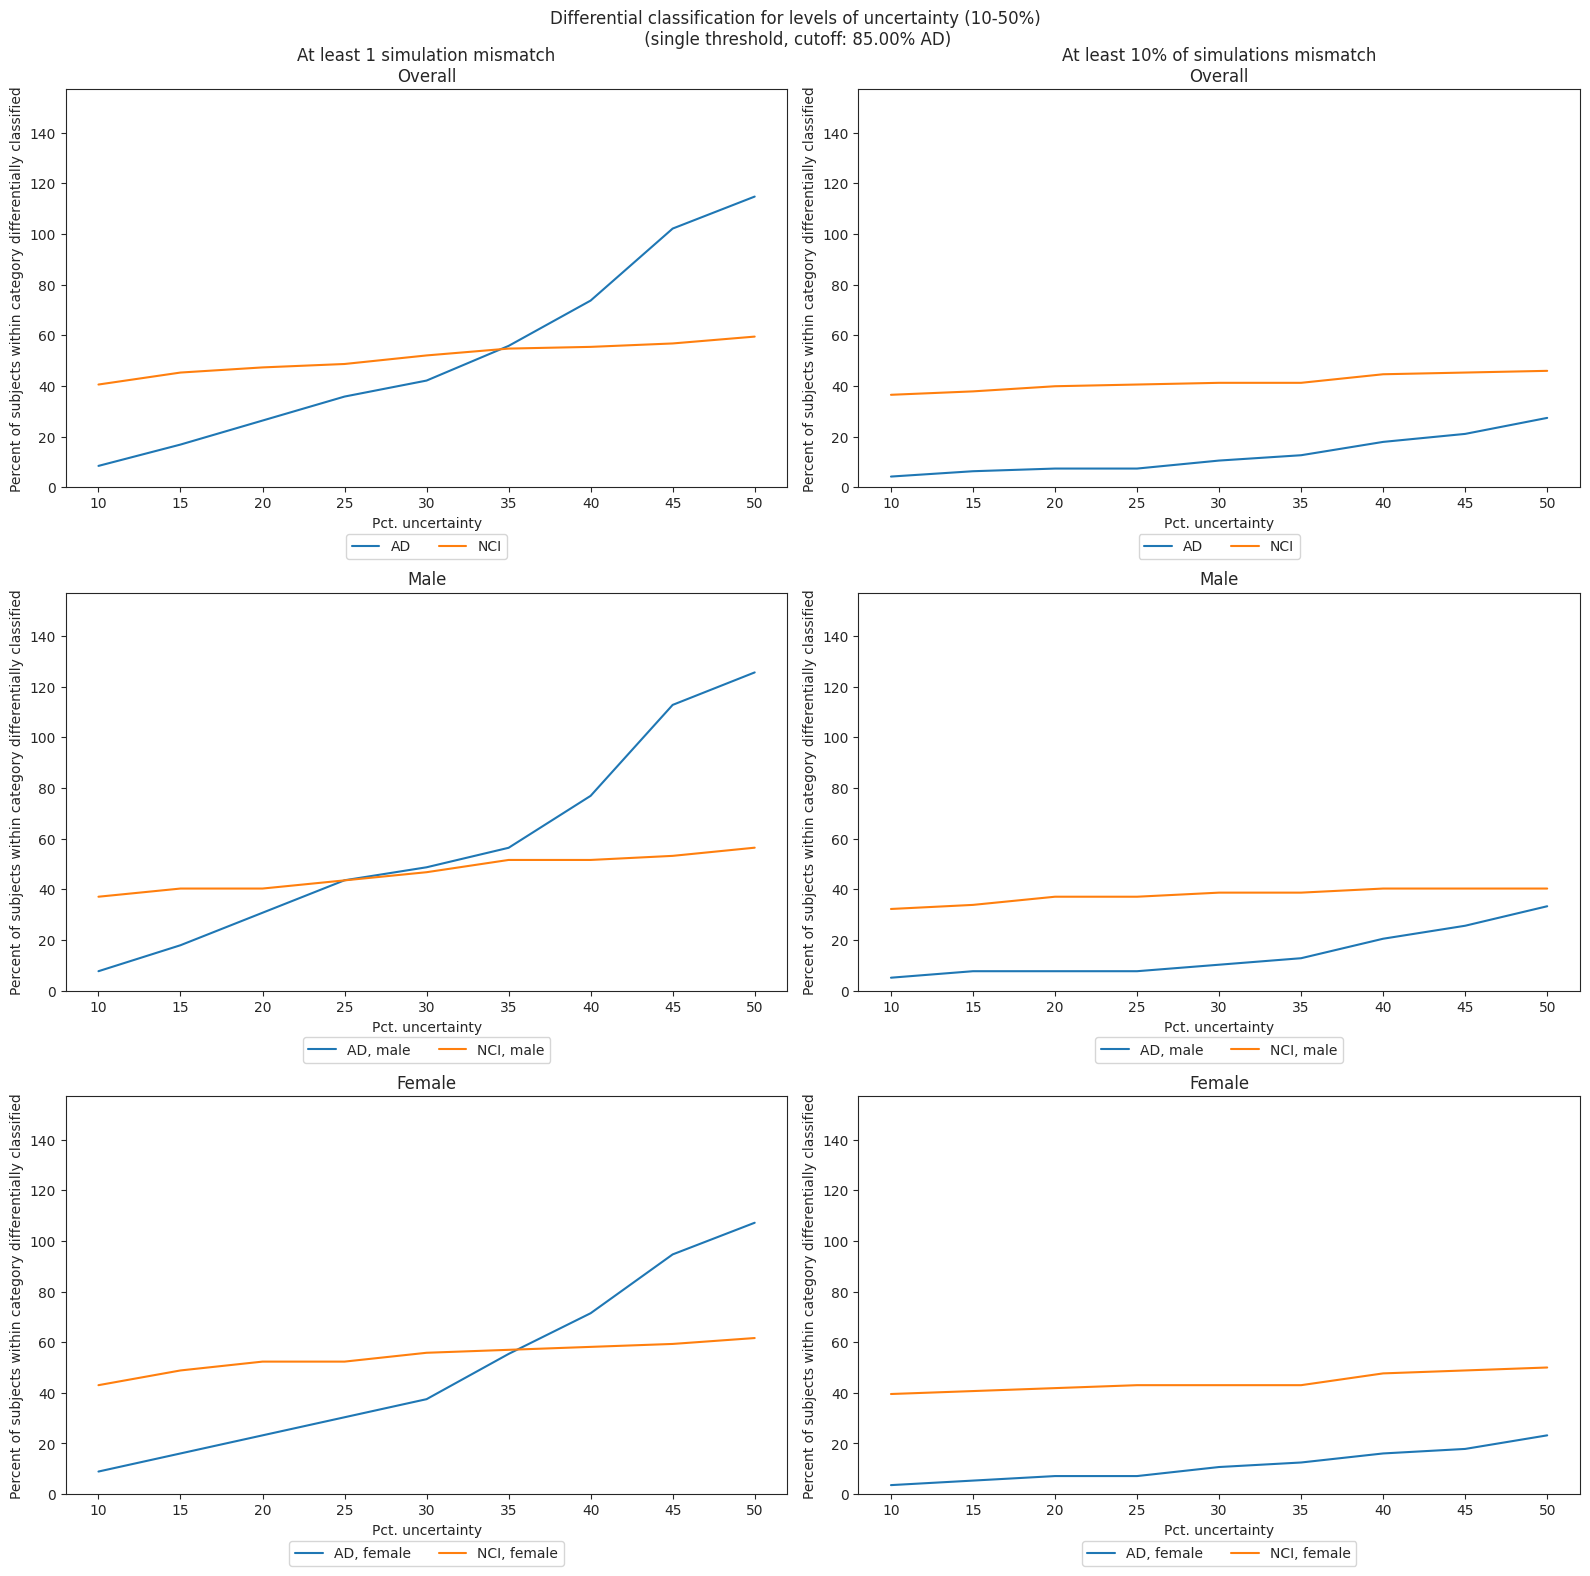

In [32]:
fig = plt.figure(figsize=(16, 16))
ylim = (min(0, single_thres_pct_diff_cls_1_diff_cls.values.min(), single_thres_pct_diff_cls.values.min() * 100), 
        1.25 * max(single_thres_pct_diff_cls_1_diff_cls.values.max(), single_thres_pct_diff_cls.values.max()) * 100)
fig.add_subplot(321)
visualize_differential_classification_results(single_thres_pct_diff_cls_1_diff_cls[["AD", "NCI"]], "At least 1 simulation mismatch\nOverall", ylim)
fig.add_subplot(322)
visualize_differential_classification_results(single_thres_pct_diff_cls[["AD", "NCI"]], "At least 10% of simulations mismatch\nOverall", ylim)

fig.add_subplot(323)
visualize_differential_classification_results(single_thres_pct_diff_cls_1_diff_cls[["AD_male", "NCI_male"]], "Male", ylim)
fig.add_subplot(324)
visualize_differential_classification_results(single_thres_pct_diff_cls[["AD_male", "NCI_male"]], "Male", ylim)

fig.add_subplot(325)
visualize_differential_classification_results(single_thres_pct_diff_cls_1_diff_cls[["AD_female", "NCI_female"]], "Female", ylim)
fig.add_subplot(326)
visualize_differential_classification_results(single_thres_pct_diff_cls[["AD_female", "NCI_female"]], "Female", ylim)
fig.suptitle(f"Differential classification for levels of uncertainty (10-50%)\n (single threshold, cutoff: {single_thres*100:.2f}% AD)")
plt.tight_layout()
fig.savefig(f"Differential classification for levels of uncertainty (10-50%) (single threshold, cutoff: {single_thres*100:.2f}% AD).png",
            bbox_inches="tight")

In [33]:
def _assign_cat(prob: float, dual_thres_low: float, dual_thres_high: float) -> str:
    if prob < dual_thres_low:
        return "NCI"
    elif dual_thres_low <= prob < dual_thres_high:
        return "Intermediate"
    else:
        return "AD"

two_thres_pathos = pathos.copy(deep=True)
two_thres_pathos["Disease (predicted)"] = gt_probs.apply(lambda x: _assign_cat(x, dual_thres_low, dual_thres_high))

two_thres_pct_diff_cls_1_diff_cls = res_1_diff_cls.dual_thres_expt_results.copy(deep=True)
two_thres_pct_diff_cls = res.dual_thres_expt_results.copy(deep=True)

two_thres_pct_diff_cls_1_diff_cls = calculate_subgroup_fractions(results=two_thres_pct_diff_cls_1_diff_cls, pathos_df=two_thres_pathos, category="AD")
two_thres_pct_diff_cls_1_diff_cls = calculate_subgroup_fractions(results=two_thres_pct_diff_cls_1_diff_cls, pathos_df=two_thres_pathos, category="Intermediate")
two_thres_pct_diff_cls_1_diff_cls = calculate_subgroup_fractions(results=two_thres_pct_diff_cls_1_diff_cls, pathos_df=two_thres_pathos, category="NCI")

two_thres_pct_diff_cls = calculate_subgroup_fractions(results=two_thres_pct_diff_cls, pathos_df=two_thres_pathos, category="AD")
two_thres_pct_diff_cls = calculate_subgroup_fractions(results=two_thres_pct_diff_cls, pathos_df=two_thres_pathos, category="Intermediate")
two_thres_pct_diff_cls = calculate_subgroup_fractions(results=two_thres_pct_diff_cls, pathos_df=two_thres_pathos, category="NCI")

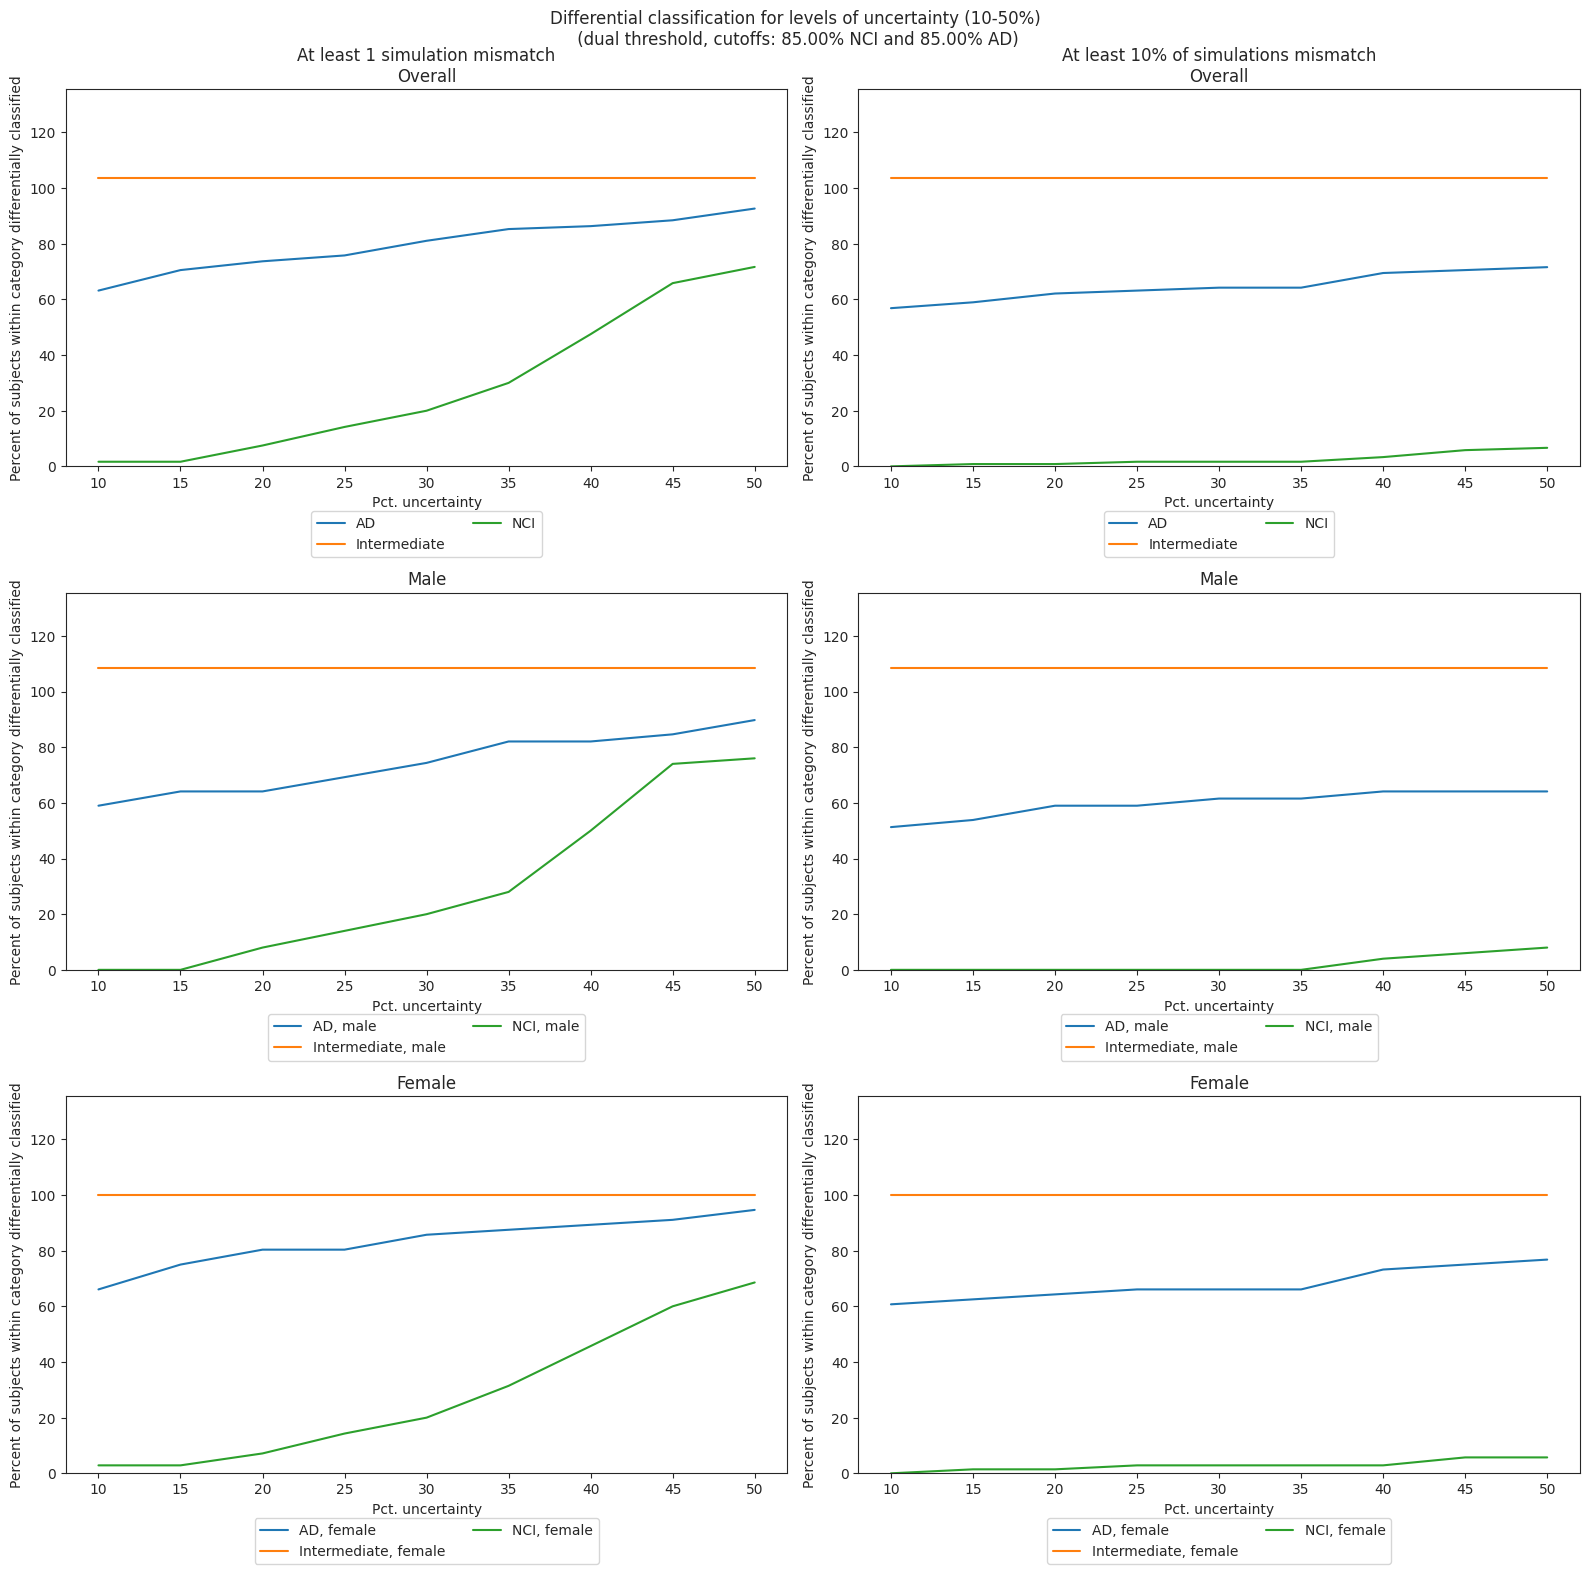

In [34]:
fig = plt.figure(figsize=(16, 16))
ylim = (min(0, two_thres_pct_diff_cls_1_diff_cls.values.min(), two_thres_pct_diff_cls.values.min() * 100), 
        1.25 * max(two_thres_pct_diff_cls_1_diff_cls.values.max(), two_thres_pct_diff_cls.values.max()) * 100)
fig.add_subplot(321)
visualize_differential_classification_results(two_thres_pct_diff_cls_1_diff_cls[["AD", "Intermediate", "NCI"]], "At least 1 simulation mismatch\nOverall", ylim)
fig.add_subplot(322)
visualize_differential_classification_results(two_thres_pct_diff_cls[["AD", "Intermediate", "NCI"]], "At least 10% of simulations mismatch\nOverall", ylim)

fig.add_subplot(323)
visualize_differential_classification_results(two_thres_pct_diff_cls_1_diff_cls[["AD_male", "Intermediate_male", "NCI_male"]], "Male", ylim)
fig.add_subplot(324)
visualize_differential_classification_results(two_thres_pct_diff_cls[["AD_male", "Intermediate_male", "NCI_male"]], "Male", ylim)

fig.add_subplot(325)
visualize_differential_classification_results(two_thres_pct_diff_cls_1_diff_cls[["AD_female", "Intermediate_female", "NCI_female"]], "Female", ylim)
fig.add_subplot(326)
visualize_differential_classification_results(two_thres_pct_diff_cls[["AD_female", "Intermediate_female", "NCI_female"]], "Female", ylim)
fig.suptitle(f"Differential classification for levels of uncertainty (10-50%)\n (dual threshold, cutoffs: {(1-dual_thres_low)*100:.2f}% NCI and {dual_thres_high*100:.2f}% AD)")
plt.tight_layout()
fig.savefig(f"Differential classification for levels of uncertainty (10-50%) (dual threshold, cutoffs: {(1-dual_thres_low)*100:.2f}% NCI and {dual_thres_high*100:.2f}% AD).png",
            bbox_inches="tight")